In [19]:
import pandas as pd
import os
import numpy as np
import requests
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
recovered_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [21]:
data = requests.get(confirmed_url)
with open('confirmed.csv','w') as file:
    file.write(data.content.decode("utf-8"))

data = requests.get(deaths_url)
with open('deaths.csv','w') as file:
    file.write(data.content.decode("utf-8"))

data = requests.get(recovered_url)
with open('recovered.csv','w') as file:
    file.write(data.content.decode("utf-8")) 

In [22]:
files = ['confirmed.csv','deaths.csv','recovered.csv']    

In [23]:
confirmed = pd.read_csv(files[0])
deaths = pd.read_csv(files[1])
recovered = pd.read_csv(files[2])

In [24]:
confirmed = confirmed.set_index('Country/Region')
deaths = deaths.set_index('Country/Region')
recovered = recovered.set_index('Country/Region')

In [25]:
# india = None
# results = pd.DataFrame()
# for i in confirmed.index:
#     _confirmed = pd.DataFrame(confirmed.loc[i])
#     _deaths = pd.DataFrame(deaths.loc[i])
#     _recovered = pd.DataFrame(recovered.loc[i])
#     _confirmed.columns = ['Confirmed']
#     _deaths.columns = ['Deaths']
#     _recovered.columns = ['Recovered']
    
#     _df = pd.concat([_confirmed,_deaths,_recovered],axis=1)
#     if(i == 'India'):
#         india = _df.iloc[-1]
#     #_df.index.Name = i
#     scaling_factor = 1 + _df.pct_change().rolling(7).mean().iloc[-1]
#     scaling_factor = scaling_factor.replace(np.nan,1)
    
#     pred = _df.ewm(com=0.1).mean().loc[_df.index[-1]]
#     pred = pred * scaling_factor
#     pred.name = i
#     results = results.append(pred)

# results = results.astype(int)

# results.loc['India']

# results.to_excel('results.xlsx',index_label = 'Country/Region')


In [164]:
india = pd.DataFrame([confirmed.loc['India'],deaths.loc['India'],recovered.loc['India']])

india = india.transpose()

india = india[3:]

india.columns = ['Confirmed','Deaths','Recovered']

india['Active'] = india['Confirmed'] - india['Deaths'] - india['Recovered']

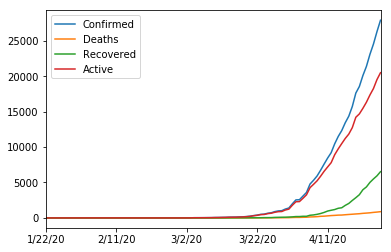

In [166]:
india.plot()
india.to_excel('results.xlsx')

In [167]:
_change = india.pct_change().rolling(window=7).mean()

In [168]:
i = india.iloc[-1] * (1 + _change.iloc[-1])

In [169]:
india = india.iloc[-1].astype(int)

In [170]:
i = i.astype(int)
i

Confirmed    29783
Deaths         940
Recovered     7345
Active       21587
Name: 4/26/20, dtype: int32

In [171]:
import email, smtplib, ssl

from email import encoders
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

subject = "COVID - 19"
body = "This is an email with attachment sent from your own COVID Tracker"
body += f'\n\nTotal Cases in India as of {india.name} are \nConfirmed = {india[0]} \nActive Cases = {india[3]} \nDeaths = {india[1]} \nRecoveries = {india[2]} \n\n'
india = i
body += f'Your predictions as of {dt.datetime.now().strftime("%b %d, %Y")} are \nConfirmed = {india[0]} \nActive Cases = {india[3]} \nDeaths = {india[1]} \nRecoveries = {india[2]} \n\n'

sender_email = os.environ['EMAIL_USER']
receiver_email = "itsmanpreetsinghjuneja@gmail.com"
password = os.environ['EMAIL_PASS']

message = MIMEMultipart()
message["From"] = sender_email
message["To"] = receiver_email
message["Subject"] = subject

message.attach(MIMEText(body, "plain"))

filename = "results.xlsx"  # In same directory as script

# Open PDF file in binary mode
with open(filename, "rb") as attachment:
    # Add file as application/octet-stream
    # Email client can usually download this automatically as attachment
    part = MIMEBase("application", "octet-stream")
    part.set_payload(attachment.read())

# Encode file in ASCII characters to send by email    
encoders.encode_base64(part)

# Add header as key/value pair to attachment part
part.add_header(
    "Content-Disposition",
    f"attachment; filename= {filename}",
)

# Add attachment to message and convert message to string
message.attach(part)
text = message.as_string()

# Log in to server using secure context and send email
context = ssl.create_default_context()
with smtplib.SMTP_SSL("smtp.gmail.com", 465, context=context) as server:
    server.login(sender_email, password)
    server.sendmail(sender_email, receiver_email, text)